In [1]:
from google.colab import drive,output
drive.mount('/content/drive') ##KS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip drive/MyDrive/datasets/optic_disc/train.zip -d train
output.clear()

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications.vgg16 import preprocess_input as pi
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
# !pip install git+https://github.com/tensorflow/examples.git
# !pip install segmentation_models

output.clear()


In [3]:
!export SM_FRAMEWORK=tf.keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
img_h=256
img_w=256


In [5]:

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
import glob
import cv2
import os
images_t = glob.glob("train/train/*.jpeg")
labels_t=pd.read_csv('drive/MyDrive/datasets/optic_disc/trainLabels.csv')

In [7]:
train_img=np.zeros((len(images_t),img_h,img_w,3),dtype=np.uint8)
# train_label=np.zeros((len(images_t),5),dtype=np.uint8)
train_label=np.zeros((len(images_t)))

In [8]:
limit={
    0:0,
    1:0,
    2:0,
    3:0,
    4:0
}

In [9]:

n=0
for i,id in tqdm(enumerate(images_t),total=len(images_t)):
  name=((id.split('/'))[-1])[:-5]
  # if limit[(labels_t[(labels_t.image==name)])['level'].values[0]]>=220:
  #   continue
  # limit[(labels_t[(labels_t.image==name)])['level'].values[0]]+=1
  img=load_img(id,target_size=(img_h,img_w))
  img=img_to_array(img)
  train_img[n]=img
  train_label[n]=(labels_t[(labels_t.image==name)])['level'].values[0]
  n+=1
  # train_label[i][(labels_t[(labels_t.image==name)])['level'].values[0]]=(labels_t[(labels_t.image==name)])['level'].values[0]

100%|██████████| 1427/1427 [01:57<00:00, 12.17it/s]


In [10]:
t_x=train_img
t_y=train_label

(array([1017.,    0.,  112.,    0.,    0.,  230.,    0.,   32.,    0.,
          36.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

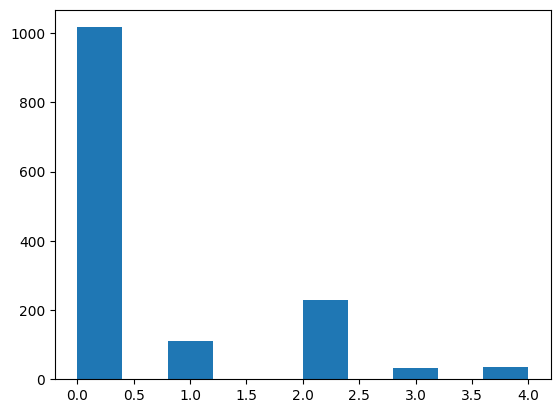

In [11]:
plt.hist(train_label)

In [12]:
from keras.utils import to_categorical
train_label=to_categorical(train_label, 5)
train_img = train_img.astype("float32")/255.

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_img, train_label, test_size = 0.1, random_state = 42)


print(np.array(x_train).shape)
print(np.array(y_train).shape)


(1284, 256, 256, 3)
(1284, 5)


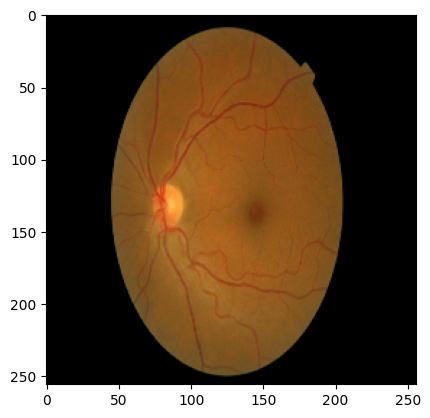

In [15]:
plt.imshow(x_train[0])

In [14]:
from keras.preprocessing.image import ImageDataGenerator
X_train = x_train
Y_train = y_train
shift = 0.2
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=360,
    width_shift_range=shift,
    height_shift_range=shift, shear_range=0.2,
    zoom_range=0.2, channel_shift_range=4.,
    horizontal_flip=True, vertical_flip=True,
    rescale=1. /255,
    fill_mode='nearest')

datagen.fit(x_train)



# Concatenating the old data with the augmented data
train_x  = np.concatenate((x_train, X_train), axis=0)
train_y  = np.concatenate((y_train, Y_train), axis=0)
print(train_x.shape)
print(train_y.shape)

(2568, 256, 256, 3)
(2568, 5)


In [15]:
from keras import backend as K
def f1(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [16]:
from keras.applications import InceptionResNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import MobileNet
from keras.applications import InceptionResNetV2

def create_model(input_shape, n_out):
    pretrain_model = PTModel(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape)
    input_tensor = Input(input_shape)
    c0 = BatchNormalization()(input_tensor)
    c1= pretrain_model(c0)
    # c1=GlobalAveragePooling2D()(c1)

    c1 = Conv2D(128,3, activation='relu')(c1)
    c1 = Flatten()(c1)
    c1 = Dropout(0.4)(c1)
    c1 = Dense(256, activation='relu')(c1)
    c1 = Dropout(0.4)(c1)
    output = Dense(n_out, activation='softmax')(c1)
    model = Model(input_tensor, output)

    return model

***-----------VGG16-----------***

In [18]:
# !unzip drive/MyDrive/datasets/optic_disc/vgg16_.zip

Archive:  drive/MyDrive/datasets/optic_disc/vgg16_.zip
   creating: vgg16_/
   creating: vgg16_/cp.ckpt/
   creating: vgg16_/cp.ckpt/assets/
 extracting: vgg16_/cp.ckpt/fingerprint.pb  
  inflating: vgg16_/cp.ckpt/keras_metadata.pb  
  inflating: vgg16_/cp.ckpt/saved_model.pb  
   creating: vgg16_/cp.ckpt/variables/
  inflating: vgg16_/cp.ckpt/variables/variables.data-00000-of-00001  
  inflating: vgg16_/cp.ckpt/variables/variables.index  


In [23]:
from keras.applications.vgg16 import VGG16 as PTModel

vgg16_model=create_model((img_h,img_w,3),5)
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001),loss='categorical_crossentropy',metrics=['accuracy',f1])
vgg16_model.summary()
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping( monitor = 'accuracy', mode = 'max', min_delta = 1,patience = 15,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''
checkpoint_path = "vgg16/cp.ckpt"

mp=ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,verbose=1)
call=[mp,es]

# vgg16_model.load_weights(checkpoint_path)

history=vgg16_model.fit(
    train_x,
    train_y,
    # validation_data=(x_test,y_test),
    validation_split=0.1,
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization_1 (Bat  (None, 256, 256, 3)       12        
 chNormalization)                                                
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 128)         589952    
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4608)              0         
                                                           

In [21]:
score = vgg16_model.evaluate(x_test, y_test,  verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9300699234008789


**--------*Resnet50*--------**

In [ ]:
# !unzip drive/MyDrive/datasets/optic_disc/resnet.zip

In [17]:
from keras.applications.resnet50 import ResNet50 as PTModel

Resnet_model=create_model((img_h,img_w,3),5)
Resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001),loss='categorical_crossentropy',metrics=['accuracy',f1])
Resnet_model.summary()
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
es = EarlyStopping( monitor = 'accuracy', mode = 'max',patience = 6,restore_best_weights = True,verbose = 2)  #'''min_delta = 1,patience = 20,'''
checkpoint_path = "resnet/cp.ckpt"

mp=ModelCheckpoint(filepath=checkpoint_path,save_best_only=True,verbose=1)
call=[mp,es]

Resnet_model.load_weights(checkpoint_path)

history=Resnet_model.fit(
    train_x,
    train_y,
    # validation_data=(x_test,y_test),
    validation_split=0.1,
    batch_size=1,
    # steps_per_epoch=100,
    epochs=10,
    callbacks=call)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 3)       12        
 Normalization)                                                  
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 128)         2359424   
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                             

*NO IMPROVEMENT AFTER 37 EPOCHS(RAN 4 TIMES THE SAME)*

In [22]:
!zip -r resnet.zip resnet
!cp -r resnet.zip 'drive/MyDrive/datasets/optic_disc/'


updating: resnet/ (stored 0%)
updating: resnet/cp.ckpt/ (stored 0%)
updating: resnet/cp.ckpt/assets/ (stored 0%)
updating: resnet/cp.ckpt/keras_metadata.pb (deflated 96%)
updating: resnet/cp.ckpt/saved_model.pb (deflated 91%)
updating: resnet/cp.ckpt/fingerprint.pb (stored 0%)
updating: resnet/cp.ckpt/variables/ (stored 0%)
updating: resnet/cp.ckpt/variables/variables.data-00000-of-00001 (deflated 8%)
updating: resnet/cp.ckpt/variables/variables.index (deflated 79%)


In [33]:
from numba import cuda
device = cuda.get_current_device()
device.reset()